## Check output of TF process
Quick plots of what the process has produced, so we can see if there are maor problems that need addressing.

31 Jul 2025 | EHU

In [1]:
import os
import sys
import copy
import csv
import time
import datetime
import math
# import dask
import cartopy.crs as ccrs ## map projections
import pandas as pd
import numpy as np
import xarray as xr
# import xesmf as xe ## more powerful regridding
import netCDF4 as nc
import matplotlib.pyplot as plt

In [2]:
DirIn = f'/Users/eultee/Library/CloudStorage/OneDrive-NASA/Data/gris-iceocean-outfiles/Summer25Test/Default_FullProcess/'

f_hist = DirIn + 'TF-ISMIP_Grid-CESM2-WACCM-1850_2014-PFromStep1-20250731.nc'
f_fut = DirIn + 'TF-ISMIP_Grid-CESM2-WACCM-1985_2101-PFromStep1-20250731.nc'

ds_hist = xr.open_dataset(f_hist)
ds_fut = xr.open_dataset(f_fut)

In [3]:
ds_hist

<xarray.Dataset> Size: 38GB
Dimensions:  (time: 1969, y: 2881, x: 1681)
Coordinates:
  * time     (time) datetime64[ns] 16kB 1850-12-31 1851-01-31 ... 2014-12-31
  * y        (y) float32 12kB -3.45e+06 -3.449e+06 ... -5.71e+05 -5.7e+05
  * x        (x) float32 7kB -7.2e+05 -7.19e+05 -7.18e+05 ... 9.59e+05 9.6e+05
Data variables:
    TF       (time, y, x) float32 38GB ...
Attributes:
    title:          QDM-corrected ocean thermal forcing for CESM2-WACCM
    summary:        TF computed following Verjans bias correction and Slater ...
    institution:    NASA Goddard Space Flight Center
    creation_date:  2025-07-31 10:53:17

In [4]:
ds_fut

<xarray.Dataset> Size: 27GB
Dimensions:  (time: 1393, y: 2881, x: 1681)
Coordinates:
  * time     (time) datetime64[ns] 11kB 1985-12-31 1986-01-31 ... 2101-12-31
  * y        (y) float32 12kB -3.45e+06 -3.449e+06 ... -5.71e+05 -5.7e+05
  * x        (x) float32 7kB -7.2e+05 -7.19e+05 -7.18e+05 ... 9.59e+05 9.6e+05
Data variables:
    TF       (time, y, x) float32 27GB ...
Attributes:
    title:          QDM-corrected ocean thermal forcing for CESM2-WACCM
    summary:        TF computed following Verjans bias correction and Slater ...
    institution:    NASA Goddard Space Flight Center
    creation_date:  2025-07-31 13:33:10

In [5]:
TF_hist_check = ds_hist.TF.sel(time=slice('1986', '2013'))
TF_fut_check = ds_fut.TF.sel(time=slice('1986', '2013'))

In [6]:
xr.testing.assert_allclose(TF_fut_check, TF_hist_check, rtol=0.1)

AssertionError: Left and right DataArray objects are not close
Differing values:
L
    array([[[14.884264, 14.884264, ..., 14.804952, 14.804952],
            [14.884264, 14.884264, ..., 14.804952, 14.804952],
            ...,
            [ 0.      ,  0.      , ...,  0.      ,  0.      ],
            [ 0.      ,  0.      , ...,  0.      ,  0.      ]],
    
           [[14.896223, 14.896223, ..., 14.803781, 14.803781],
            [14.896223, 14.896223, ..., 14.803781, 14.803781],
            ...,
            [ 0.      ,  0.      , ...,  0.      ,  0.      ],
            [ 0.      ,  0.      , ...,  0.      ,  0.      ]],
    
           ...,
    
           [[14.691367, 14.691367, ..., 14.870121, 14.870121],
            [14.691367, 14.691367, ..., 14.870121, 14.870121],
            ...,
            [ 0.      ,  0.      , ...,  0.      ,  0.      ],
            [ 0.      ,  0.      , ...,  0.      ,  0.      ]],
    
           [[14.716906, 14.716906, ..., 14.87326 , 14.87326 ],
            [14.716906, 14.716906, ..., 14.87326 , 14.87326 ],
            ...,
            [ 0.      ,  0.      , ...,  0.      ,  0.      ],
            [ 0.      ,  0.      , ...,  0.      ,  0.      ]]],
          shape=(336, 2881, 1681), dtype=float32)
R
    array([[[14.882524, 14.882524, ..., 14.795787, 14.795787],
            [14.882524, 14.882524, ..., 14.795787, 14.795787],
            ...,
            [ 0.      ,  0.      , ...,  0.      ,  0.      ],
            [ 0.      ,  0.      , ...,  0.      ,  0.      ]],
    
           [[14.894483, 14.894483, ..., 14.794616, 14.794616],
            [14.894483, 14.894483, ..., 14.794616, 14.794616],
            ...,
            [ 0.      ,  0.      , ...,  0.      ,  0.      ],
            [ 0.      ,  0.      , ...,  0.      ,  0.      ]],
    
           ...,
    
           [[14.756929, 14.756929, ..., 14.875412, 14.875412],
            [14.756929, 14.756929, ..., 14.875412, 14.875412],
            ...,
            [ 0.      ,  0.      , ...,  0.      ,  0.      ],
            [ 0.      ,  0.      , ...,  0.      ,  0.      ]],
    
           [[14.785387, 14.785387, ..., 14.872679, 14.872679],
            [14.785387, 14.785387, ..., 14.872679, 14.872679],
            ...,
            [ 0.      ,  0.      , ...,  0.      ,  0.      ],
            [ 0.      ,  0.      , ...,  0.      ,  0.      ]]],
          shape=(336, 2881, 1681), dtype=float32)

This test says that some values are not within 10% of each other, but it's not clear which.  Possible these are edge effects, outliers, etc.  Let's check on a map view:

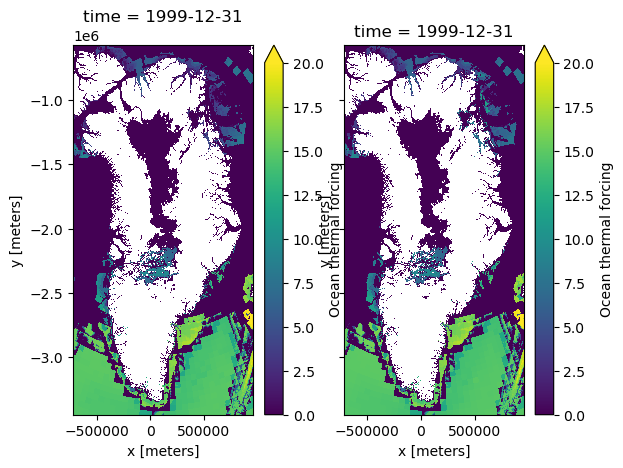

In [7]:
fig, axs = plt.subplots(1,2, sharex=True, sharey=True)
TF_hist_check.sel(time='2000', method='nearest').plot(ax=axs[0], vmin=0., vmax=20.)
TF_fut_check.sel(time='2000', method='nearest').plot(ax=axs[1], vmin=0., vmax=20.)

Now extract some time series:

In [8]:
## select sites to plot, in latlon coords (deg N, deg E)
example_sites = {'Sermilik': (65.5, 0.5),
                 'SK': (69.0, -56.0),
                 '79N': (82.5, -18)
                }

verts = [(65.5, 0.5),
         (69.0, -56.0),
         (82.5, -18)
]
verts= np.asarray(verts)


import cartopy.crs as ccrs
proj_ismip = ccrs.epsg(3413)
proj_latlon = ccrs.PlateCarree()

transformed_sites = proj_ismip.transform_points(proj_latlon, verts[:,1], verts[:,0])
transformed_sites

array([[ 1921196.11765338, -1887954.16672647,        0.        ],
       [ -438795.4100585 , -2257406.68900577,        0.        ],
       [  369353.09199213,  -724896.25858457,        0.        ]])

In [9]:
transformed_sites[0][0]

np.float64(1921196.1176533848)

[Text(0.5, 1.0, 'Example site 2')]

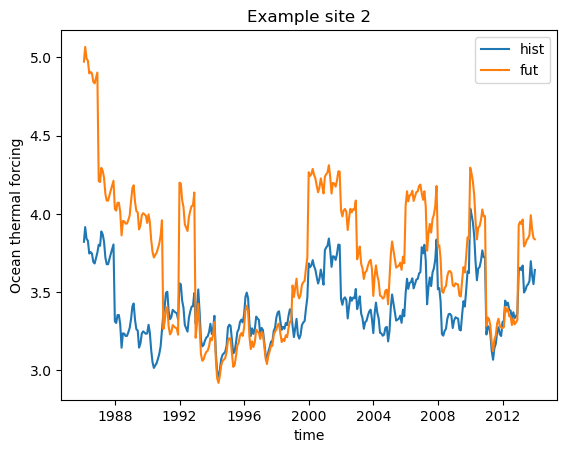

In [10]:
which_site = 2
coords_to_select = transformed_sites[which_site]

fig, ax = plt.subplots()
TF_hist_check.sel(x=coords_to_select[0], y=coords_to_select[1], method='nearest').plot(ax=ax, label='hist')
TF_fut_check.sel(x=coords_to_select[0], y=coords_to_select[1], method='nearest').plot(ax=ax, label='fut')
ax.legend()
ax.set(title='Example site {}'.format(which_site))

Check full length time series for these spots:

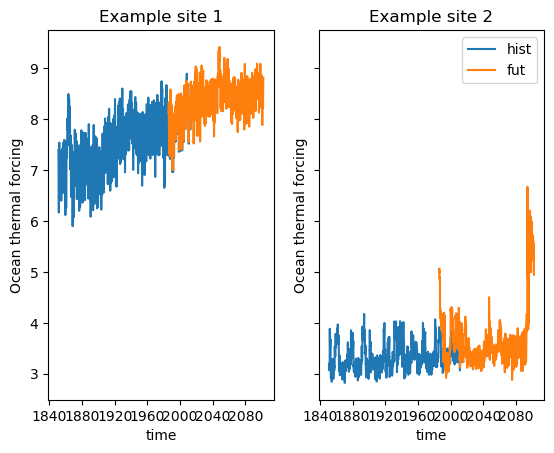

In [11]:
# which_site = 2
# coords_to_select = transformed_sites[which_site]

fig, axs = plt.subplots(1,2, sharex=True, sharey=True)
for i in range(2):
    ax=axs[i]
    which_site = i+1 ## skip site 0
    coords_to_select = transformed_sites[which_site]
    ds_hist.TF.sel(x=coords_to_select[0], y=coords_to_select[1], method='nearest').plot(ax=ax, label='hist')
    ds_fut.TF.sel(x=coords_to_select[0], y=coords_to_select[1], method='nearest').plot(ax=ax, label='fut')
    ax.set(title='Example site {}'.format(which_site))
axs[1].legend()